In [143]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss
from scipy.stats import binned_statistic
from sklearn.metrics import brier_score_loss

In [144]:
df = pd.read_excel("../data/predictions.xlsx")
df = df[["home_odds", "away_odds", "draw_odds", "market_home_odds", "market_away_odds", "market_draw_odds", "over_25_odds", "under_25_odds", "market_over_25_odds", "market_under_25_odds", "home_goals", "away_goals"]]
df = df.dropna()

odds_cols = [
    "home_odds",
    "away_odds",
    "draw_odds",
    "market_home_odds",
    "market_away_odds",
    "market_draw_odds",
    "over_25_odds",
    "under_25_odds",
    "market_over_25_odds",
    "market_under_25_odds"
]

df[odds_cols] = 1 / df[odds_cols]

df['total_goals'] = df['home_goals'] + df['away_goals']
df['actual_outcome'] = np.where(df['home_goals'] > df['away_goals'], 0, np.where(df['home_goals'] == df['away_goals'], 1, 2))
df['actual_over_25'] = (df['total_goals'] > 2.5).astype(int)

df

,home_odds,away_odds,draw_odds,market_home_odds,market_away_odds,market_draw_odds,over_25_odds,under_25_odds,market_over_25_odds,market_under_25_odds,home_goals,away_goals,total_goals,actual_outcome,actual_over_25
0,0.266028,0.491642,0.242424,0.472813,0.296648,0.280899,0.633714,0.366435,0.571429,0.476190,2,1,3,0,1
1,0.459348,0.276472,0.264201,0.680272,0.158178,0.209952,0.580046,0.420168,0.662252,0.387597,2,0,2,0,0
2,0.421941,0.291971,0.286123,0.755858,0.117014,0.176460,0.515198,0.484966,0.675676,0.377358,4,0,4,0,1
3,0.686813,0.104899,0.208420,0.796178,0.092507,0.163079,0.473485,0.526593,0.684932,0.374532,3,1,4,0,1
4,0.668896,0.119904,0.211015,0.897666,0.056821,0.100220,0.582072,0.417885,0.793651,0.267380,2,1,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
480,0.386847,0.261097,0.351989,0.423191,0.312402,0.308071,0.203293,0.796813,0.438596,0.602410,1,0,1,0,0
481,0.229200,0.450045,0.320718,0.363769,0.396511,0.289603,0.345543,0.654450,0.520833,0.520833,1,1,2,1,0
482,0.318573,0.376932,0.304507,0.345543,0.410846,0.297708,0.382848,0.617284,0.531915,0.520833,0,1,1,2,0
483,0.240790,0.349040,0.410172,0.092911,0.819001,0.147754,0.156299,0.843882,0.746269,0.324675,3,1,4,0,1


In [145]:
# Log Loss
# Model 1X2
probs_1x2 = df[['home_odds', 'draw_odds', 'away_odds']].values
probs_1x2_norm = probs_1x2 / probs_1x2.sum(axis=1, keepdims=True)
loss_1x2_norm = log_loss(df['actual_outcome'], probs_1x2_norm)
print(f"Model 1X2 Log Loss (normalized): {loss_1x2_norm:.4f}")

# Model Over/Under
probs_ou = df[['under_25_odds', 'over_25_odds']].values
probs_ou_norm = probs_ou / probs_ou.sum(axis=1, keepdims=True)
loss_ou_norm = log_loss(df['actual_over_25'], probs_ou_norm)
print(f"Model Over/Under Log Loss (normalized): {loss_ou_norm:.4f}")

# Market 1X2
print("")
market_probs_1x2 = df[['market_home_odds', 'market_draw_odds', 'market_away_odds']].values
market_probs_1x2_norm = market_probs_1x2 / market_probs_1x2.sum(axis=1, keepdims=True)
market_loss_1x2_norm = log_loss(df['actual_outcome'], market_probs_1x2_norm)
print(f"Market 1X2 Log Loss (normalized): {market_loss_1x2_norm:.4f}")

# Market Over/Under
market_probs_ou = df[['market_under_25_odds', 'market_over_25_odds']].values
market_probs_ou_norm = market_probs_ou / market_probs_ou.sum(axis=1, keepdims=True)
market_loss_ou_norm = log_loss(df['actual_over_25'], market_probs_ou_norm)
print(f"Market Over/Under Log Loss (normalized): {market_loss_ou_norm:.4f}")

Model 1X2 Log Loss (normalized): 1.0587
Model Over/Under Log Loss (normalized): 0.6789

Market 1X2 Log Loss (normalized): 1.0342
Market Over/Under Log Loss (normalized): 0.6820


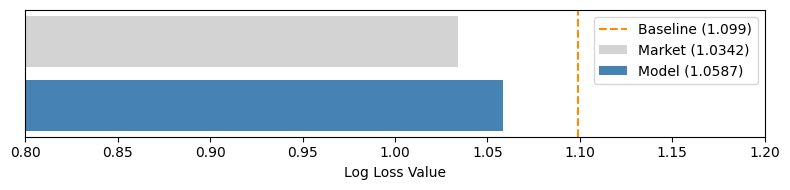

In [146]:
# 1X2
model_value = 1.0587
market_value = 1.0342
baseline_value = 1.099

fig, ax = plt.subplots(figsize=(8, 2))
ax.set_xlim(0.8, 1.2)
plt.xlabel("Log Loss Value")

ax.barh(1, market_value, color="lightgray", label=f"Market ({market_value:.4f})")
ax.barh(0, model_value, color="steelblue", label=f"Model ({model_value:.4f})")

ax.axvline(
    baseline_value,
    color="darkorange",
    linestyle="--",
    linewidth=1.5,
    label="Baseline (1.099)"
)

ax.set_yticks([])
plt.legend()
plt.tight_layout()
plt.show()


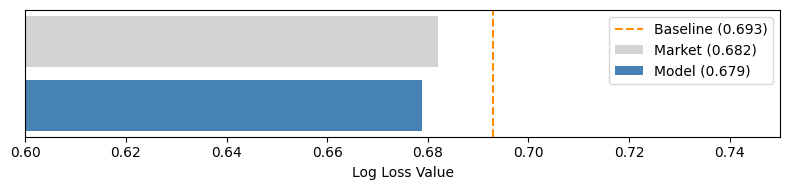

In [185]:
# ou
model_value = 0.6789
market_value = 0.6820
baseline_value = 0.693

fig, ax = plt.subplots(figsize=(8, 2))
ax.set_xlim(0.6, 0.75)
plt.xlabel("Log Loss Value")

ax.barh(1, market_value, color="lightgray", label=f"Market ({market_value:.3f})")
ax.barh(0, model_value, color="steelblue", label=f"Model ({model_value:.3f})")

ax.axvline(
    baseline_value,
    color="darkorange",
    linestyle="--",
    linewidth=1.5,
    label=f"Baseline ({baseline_value:.3f})"
)

ax.set_yticks([])
plt.legend()
plt.tight_layout()
plt.show()

In [147]:
# Ranked Probability Score (RPS)
def ranked_probability_score(y_true, y_pred):
    """
    Compute Ranked Probability Score (RPS) for ordinal outcomes.
    
    Parameters:
    y_true : array-like of shape (n_samples,)
        True labels, encoded as 0, 1, 2 (home, draw, away in that order).
    y_pred : array-like of shape (n_samples, 3)
        Predicted probabilities for each class (must sum to 1 per row).
    
    Returns:
    rps : float
        Mean RPS over all samples (lower is better, range 0 to 1).
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Cumulative probabilities for predictions
    cum_pred = np.cumsum(y_pred, axis=1)[:, :-1]  # exclude last category
    
    # Cumulative probabilities for true outcomes (one-hot encoded)
    n_samples = len(y_true)
    y_onehot = np.zeros((n_samples, 3))
    y_onehot[np.arange(n_samples), y_true] = 1
    cum_true = np.cumsum(y_onehot, axis=1)[:, :-1]
    
    # Squared differences summed over the first K-1 categories
    squared_diff = (cum_pred - cum_true) ** 2
    rps_per_sample = np.mean(squared_diff, axis=1)  # divide by (K-1) = 2
    return np.mean(rps_per_sample)

# Model RPS for 1X2
model_rps = ranked_probability_score(df['actual_outcome'], probs_1x2_norm)
print(f"Model 1X2 RPS: {model_rps:.4f}")

# Market RPS for 1X2
market_rps = ranked_probability_score(df['actual_outcome'], market_probs_1x2_norm)
print(f"Market 1X2 RPS: {market_rps:.4f}")

Model 1X2 RPS: 0.2148
Market 1X2 RPS: 0.2079


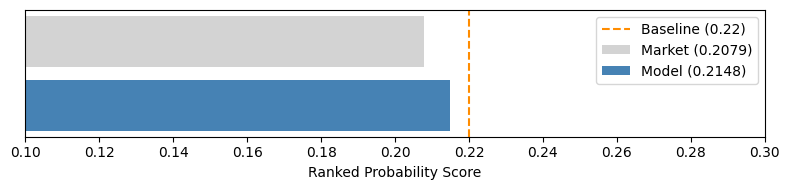

In [148]:
# 1X2
model_value = 0.2148
market_value = 0.2079
baseline_value = 0.22

fig, ax = plt.subplots(figsize=(8, 2))
ax.set_xlim(0.1, 0.3)
plt.xlabel("Ranked Probability Score")

ax.barh(1, market_value, color="lightgray", label=f"Market ({market_value:.4f})")
ax.barh(0, model_value, color="steelblue", label=f"Model ({model_value:.4f})")

ax.axvline(
    baseline_value,
    color="darkorange",
    linestyle="--",
    linewidth=1.5,
    label=f"Baseline ({baseline_value:.2f})"
)

ax.set_yticks([])
ax.set_xticks(np.arange(0.1, 0.31, 0.02))

plt.legend()
plt.tight_layout()
plt.show()

In [149]:
# Brier Score
# Model Over/Under 
model_over_prob = probs_ou_norm[:, 1]
model_brier = brier_score_loss(df['actual_over_25'], model_over_prob)
print(f"Model Over/Under Brier Score: {model_brier:.4f}")

# Market Over/Under Brier Score
market_over_prob = market_probs_ou_norm[:, 1]
market_brier = brier_score_loss(df['actual_over_25'], market_over_prob)
print(f"Market Over/Under Brier Score: {market_brier:.4f}")

Model Over/Under Brier Score: 0.2424
Market Over/Under Brier Score: 0.2442


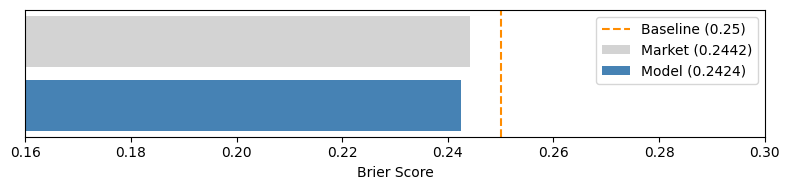

In [192]:
# ou
model_value = 0.2424
market_value = 0.2442
baseline_value = 0.25

fig, ax = plt.subplots(figsize=(8, 2))
ax.set_xlim(0.16, 0.3)
plt.xlabel("Brier Score")

ax.barh(1, market_value, color="lightgray", label=f"Market ({market_value:.4f})")
ax.barh(0, model_value, color="steelblue", label=f"Model ({model_value:.4f})")

ax.axvline(
    baseline_value,
    color="darkorange",
    linestyle="--",
    linewidth=1.5,
    label=f"Baseline ({baseline_value:.2f})"
)

ax.set_yticks([])
ax.set_xticks(np.arange(0.16, 0.31, 0.02))

plt.legend()
plt.tight_layout()
plt.show()

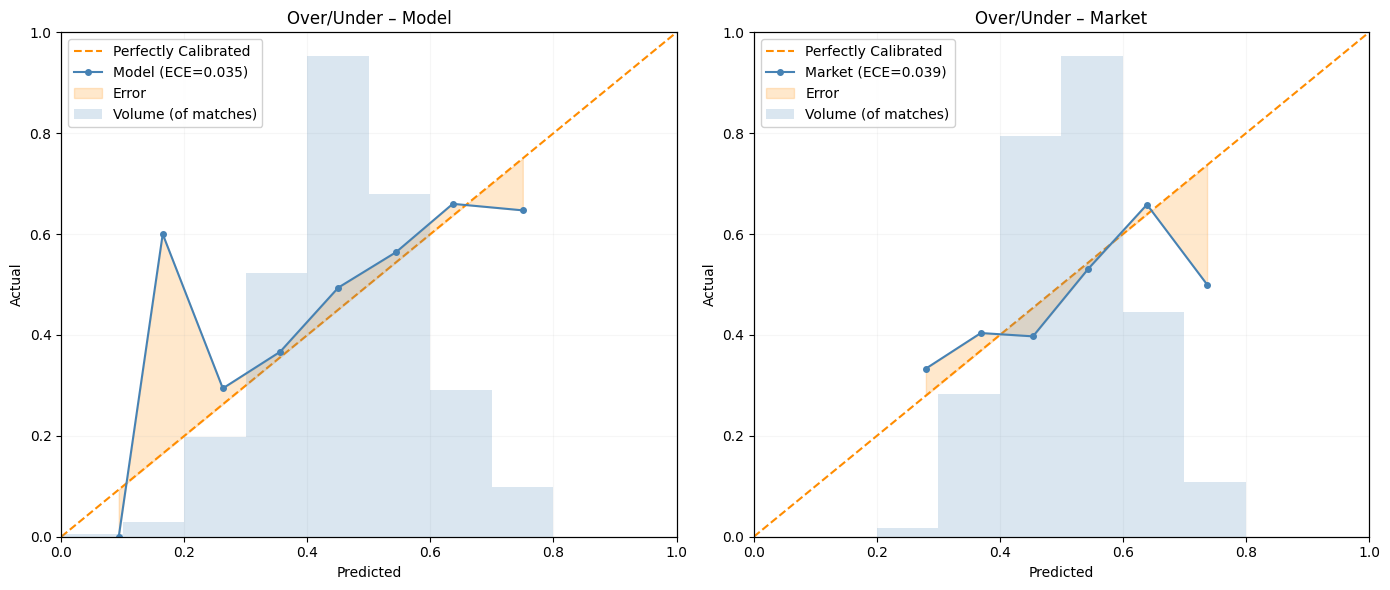

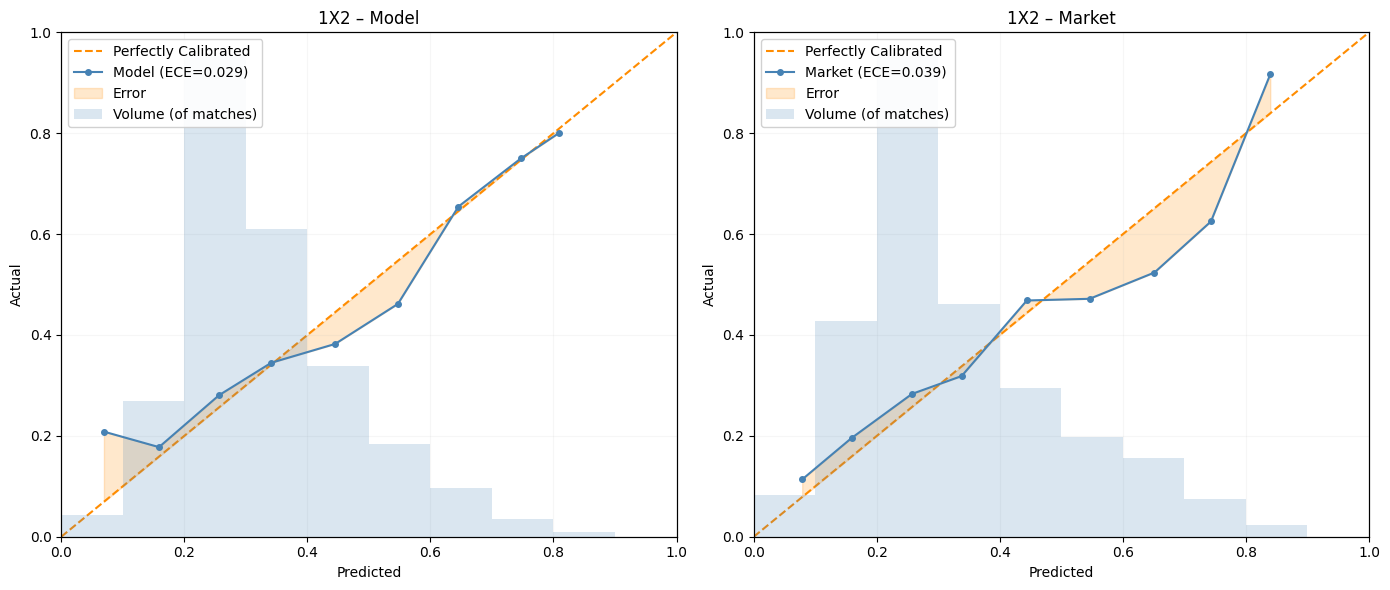

Over/Under Model ECE: 0.0351
Over/Under Market ECE: 0.0392
1X2 Model ECE: 0.0292
1X2 Market ECE: 0.0391


In [175]:
def compute_calibration(y_true, y_pred_prob, n_bins=10):
    """
    Computes calibration metrics, ensuring we handle empty bins correctly
    later in the plotting stage.
    """
    # Define bin edges
    bin_edges = np.linspace(0, 1, n_bins + 1)
    
    # digitize returns 1-based indices, we subtract 1 to get 0-based
    # We clip to ensure 0.0 and 1.0 are handled safely within bounds
    bin_indices = np.digitize(y_pred_prob, bin_edges[1:-1])
    
    bin_sums = np.zeros(n_bins)
    bin_counts = np.zeros(n_bins)
    bin_true = np.zeros(n_bins)
    
    for i in range(n_bins):
        in_bin = (bin_indices == i)
        if np.sum(in_bin) > 0:
            bin_counts[i] = np.sum(in_bin)
            bin_true[i] = np.sum(y_true[in_bin])
            bin_sums[i] = np.sum(y_pred_prob[in_bin])
    
    # Calculate Accuracy and Confidence
    # We keep zeros where counts are zero, but we will filter them out during plotting
    bin_acc = np.zeros(n_bins)
    bin_conf = np.zeros(n_bins)
    
    mask = bin_counts > 0
    bin_acc[mask] = bin_true[mask] / bin_counts[mask]
    bin_conf[mask] = bin_sums[mask] / bin_counts[mask]
    
    # ECE Calculation
    total_count = np.sum(bin_counts)
    ece = np.sum(bin_counts * np.abs(bin_acc - bin_conf)) / total_count if total_count > 0 else 0
    
    return bin_conf, bin_acc, ece, bin_counts

def plot_calibration(conf, acc, ece, bin_counts, title, model_label="Model", ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
        
    # 1. PLOT THE HISTOGRAM (Distribution of predictions)
    ax_hist = ax.twinx()

    n_bins = len(bin_counts)
    bin_centers = np.linspace(0.05, 0.95, n_bins) 
    
    ax_hist.bar(bin_centers, bin_counts, width=1.0/n_bins, color='steelblue', alpha=0.2, label='Volume (of matches)')
    ax_hist.set_yticks([])
    
    # 2. PLOT THE CALIBRATION CURVE
    mask = bin_counts > 0
    conf_valid = conf[mask]
    acc_valid = acc[mask]

    ax.plot([0, 1], [0, 1], linestyle='--', color="darkorange", label='Perfectly Calibrated')
    ax.plot(conf_valid, acc_valid, marker='o', markersize=4, color="steelblue", linewidth=1.5, label=f'{model_label} (ECE={ece:.3f})')

    ax.fill_between(conf_valid, conf_valid, acc_valid, color="darkorange", alpha=0.2, label="Error")

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_title(title)
    handles1, labels1 = ax.get_legend_handles_labels()
    handles2, labels2 = ax_hist.get_legend_handles_labels()
    ax_hist.legend(handles1 + handles2, labels1 + labels2, loc="upper left", framealpha=0.9)
    ax.grid(True, alpha=0.1)
    
    return ax

# ------------------------------
# 1. Over/Under (Binary) Calibration
# ------------------------------
# Compute calibration
conf_model_ou, acc_model_ou, ece_model_ou, counts_model_ou = compute_calibration(df['actual_over_25'], model_over_prob)
conf_market_ou, acc_market_ou, ece_market_ou, counts_market_ou = compute_calibration(df['actual_over_25'], market_over_prob)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14,6))
plot_calibration(conf_model_ou, acc_model_ou, ece_model_ou, counts_model_ou,
                 title="Over/Under – Model", model_label="Model", ax=axes[0])

plot_calibration(conf_market_ou, acc_market_ou, ece_market_ou, counts_market_ou,
                 title="Over/Under – Market", model_label="Market", ax=axes[1])
plt.tight_layout()
plt.show()

# ------------------------------
# 2. 1X2 (Multi-class) Calibration
# ------------------------------
conf_model_mc, acc_model_mc, ece_model_mc, counts_model_mc = compute_calibration(model_indicators, model_probs_flat)
conf_market_mc, acc_market_mc, ece_market_mc, counts_market_mc = compute_calibration(market_indicators, market_probs_flat)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14,6))
plot_calibration(conf_model_mc, acc_model_mc, ece_model_mc, counts_model_mc,
                 title="1X2 – Model", model_label="Model", ax=axes[0])

plot_calibration(conf_market_mc, acc_market_mc, ece_market_mc, counts_market_mc,
                 title="1X2 – Market", model_label="Market", ax=axes[1])
plt.tight_layout()
plt.show()

# Print ECE values
print(f"Over/Under Model ECE: {ece_model_ou:.4f}")
print(f"Over/Under Market ECE: {ece_market_ou:.4f}")
print(f"1X2 Model ECE: {ece_model_mc:.4f}")
print(f"1X2 Market ECE: {ece_market_mc:.4f}")